In [1]:
# 라이브러리
import os
import sys
import urllib.request
import re
import pandas as pd
import time
from bs4 import BeautifulSoup
import numpy as np
import requests
from naver_blog_api import naver_blog # .py 파일 동일한 폴더 내에 저장할 것
from konlpy.tag import Okt
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline

### 네이버 블로그 API 및 bs4

In [2]:
client_id = "발급받은 api id"
client_secret = "발급받은 api 비밀번호"

In [3]:
# client_id, client_secret, 검색어, 가져올 개수, 시작 위치
# 가져올 개수 : 기본값 10, 최대 100
# 시작 위치 : 기본값 1, 최대 100
blog_temp = naver_blog(client_id, client_secret, "전주 관광", 100, 1)
temp = blog_temp.blog_api()
temp_df1 = blog_temp.preprocessing(temp)
temp_df1

,title,link,postdate,text
0,전주한옥마을 인근 도보 10분컷 층고높고 쾌적한 &quot;전주관광꽃심...,https://blog.naver.com/ddubiwiki/223112693525,20230526,NaN
1,[전주한옥마을 숙소] 전주관광호텔 꽃심,https://blog.naver.com/hjseo1987/222905809649,20221020,NaN
2,[전북\/전주\/완산구] 전주관광호텔 꽃심,https://blog.naver.com/yangs7149/222832975166,20220731,NaN
3,전주에서 삶을 경험하다. 전주생활관광 &apos;당신만의 전주&apos;,https://blog.naver.com/jeonju_city/222919734201,20221104,NaN
4,전주 여행 전주 한옥마을 관광 경기전 전동성당 길거리 구경,https://blog.naver.com/chjcys/223011258386,20230210,NaN
5,전주 생활관광 기록투어 1일차 - 도보여행 &amp; 판소리 체험...,https://blog.naver.com/lamanoworks/222924348440,20221110,NaN
6,전주영화제부터 전주 관광코스 둘러보기,https://blog.naver.com/y461985/223097068299,20230509,NaN
7,전주만의 로컬관광 키워 글로벌 관광산업도시로,https://blog.naver.com/leebangheui/223104370005,20230517,NaN
8,[온세대교회]2023년 온세대교회 효도관광- 전주 목포,https://blog.naver.com/daumsedaecc/223109811991,20230523,NaN
9,전주 한옥마을 온라인 스탬프투어 (+관광택시),https://blog.naver.com/story_jc/222986360096,20230116,NaN


In [6]:
### 본문 크롤링
def text_crawl(dataframe):
    for i,j in enumerate(dataframe['link']):
        if pd.isnull(dataframe.loc[i, 'text']): #아직 크롤링되지 않은 부분부터
            resp = requests.get(j, timeout=3)
            soup = BeautifulSoup(resp.content, "html.parser")

            # 수집할 수 있는 url 파싱
            url = "https://blog.naver.com/"+soup.iframe['src']
            resp = requests.get(url, timeout=3)
            soup = BeautifulSoup(resp.content, "html.parser")
            
            #  본문 크롤링
            if soup.find("div", attrs={'class':'se-main-container'}):
                text = soup.find("div", attrs={'class':'se-main-container'}).get_text()
                text = text.replace("\n", "")
            else:
                text = 'None'
            dataframe.loc[i, 'text'] = text

In [7]:
text_crawl(temp_df1) #본문 크롤링

In [8]:
temp_df1.head() #크롤링 결과 확인

,title,link,postdate,text
0,전주한옥마을 인근 도보 10분컷 층고높고 쾌적한 &quot;전주관광꽃심...,https://blog.naver.com/ddubiwiki/223112693525,20230526,한옥마을 인근 전주관광호텔꽃심 ​총 3명이 묵어야해서 디럭스패밀리룸으로 아고다 최...
1,[전주한옥마을 숙소] 전주관광호텔 꽃심,https://blog.naver.com/hjseo1987/222905809649,20221020,​지난 주 전주여행을 하면서 저희가 묵었던 전주관광호텔 꽃심에 대해 포스팅해보려고 ...
2,[전북\/전주\/완산구] 전주관광호텔 꽃심,https://blog.naver.com/yangs7149/222832975166,20220731,​이번에는 부모님과 함께 전주에 오게되었는데요어디서 묵을까 하다가부모님과 한옥마을...
3,전주에서 삶을 경험하다. 전주생활관광 &apos;당신만의 전주&apos;,https://blog.naver.com/jeonju_city/222919734201,20221104,"선선한 가을, 특별한 여행을 떠나고 싶으신가요? 오늘은 여러분께 아이와 함께, 친구..."
4,전주 여행 전주 한옥마을 관광 경기전 전동성당 길거리 구경,https://blog.naver.com/chjcys/223011258386,20230210,안녕하세요체리맘이에요 🍒🍒 ​1박 2일 동안 전주 한옥마을 중심으로 전주 여행을 다...


### 워드클라우드 시각화

In [24]:
### count 기준 워드클라우드
## 전처리 : 한글만 남기기 - 형태소 분석 - 불용어 제거
temp_df1['text clean'] = np.nan

for i,j in enumerate(temp_df1['text']):
    tokenizer = Okt()

    k = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', "", j) #한글과 공백만 남기기
    #명사만 남기기 & 한 글자 형태소는 제외
    new_k = list()
    for w in tokenizer.nouns(k):
        if (len(w) != 1):
            new_k.append(w)
    #불용어 제거
    stop_word = ['전주', '전라북도', '전북', '여행', '전주시']
    token = [t for t in new_k if t not in stop_word]
    text = ' '.join(token)

    temp_df1.loc[i, 'text clean'] = text

In [25]:
temp_df1.head()

,title,link,postdate,text,text clean
0,전주한옥마을 인근 도보 10분컷 층고높고 쾌적한 &quot;전주관광꽃심...,https://blog.naver.com/ddubiwiki/223112693525,20230526,한옥마을 인근 전주관광호텔꽃심 ​총 3명이 묵어야해서 디럭스패밀리룸으로 아고다 최...,마을 인근 관광 호텔 꽃심 디럭스 패밀리 아고다 최저 예약 네이버 예약 관광 호텔 ...
1,[전주한옥마을 숙소] 전주관광호텔 꽃심,https://blog.naver.com/hjseo1987/222905809649,20221020,​지난 주 전주여행을 하면서 저희가 묵었던 전주관광호텔 꽃심에 대해 포스팅해보려고 ...,지난 저희 관광 호텔 꽃심 대해 포스팅 마을 접근성 고도보 내외 무엇 시설 컨디션 ...
2,[전북\/전주\/완산구] 전주관광호텔 꽃심,https://blog.naver.com/yangs7149/222832975166,20220731,​이번에는 부모님과 함께 전주에 오게되었는데요어디서 묵을까 하다가부모님과 한옥마을...,이번 부모님 부모님 마을 남부 시장 이동 관광 호텔 꽃심 발음 고급 지고 일리 호텔...
3,전주에서 삶을 경험하다. 전주생활관광 &apos;당신만의 전주&apos;,https://blog.naver.com/jeonju_city/222919734201,20221104,"선선한 가을, 특별한 여행을 떠나고 싶으신가요? 오늘은 여러분께 아이와 함께, 친구...",선선 가을 가요 오늘 여러분 아이 친구 혼자 진짜 기록 투어 당신 소개 일차 도심 ...
4,전주 여행 전주 한옥마을 관광 경기전 전동성당 길거리 구경,https://blog.naver.com/chjcys/223011258386,20230210,안녕하세요체리맘이에요 🍒🍒 ​1박 2일 동안 전주 한옥마을 중심으로 전주 여행을 다...,체리 동안 마을 중심 가족 친구 이야기 정말 서울역 출산 처음 지방 친구 모임 전주...


In [26]:
# 말뭉치 리스트 생성
word_list = list()
for t in temp_df1['text clean']:
    word_list.append(t.split(" "))
word_list = sum(word_list, []) # 2차원 1차원으로 변환
len(word_list)

2771

In [27]:
c = Counter(word_list)
word_dict = dict(c.most_common(300)) # 가장 많이 등장한 300개만

In [28]:
#워드클라우드 설정
wc = WordCloud(font_path = 'BCcardB',
               background_color = 'white',
               width = 3000, height = 2000,
               min_font_size = 10) 

# 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.family'] = 'Malgun Gothic'

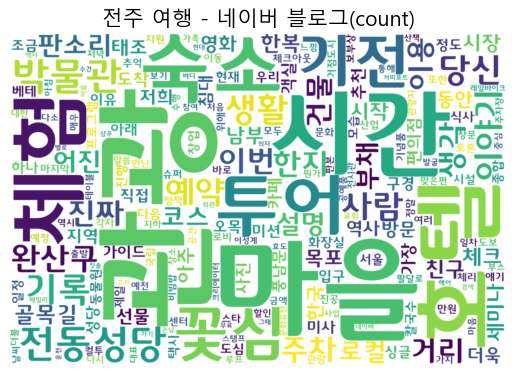

In [29]:
cloud = wc.generate_from_frequencies(word_dict)
plt.imshow(cloud, interpolation='bilinear')
plt.title("전주 여행 - 네이버 블로그(count)", fontsize = 15)
plt.axis('off')
plt.show()

In [31]:
# tfidf vectorizer wordcloud
def tfidf_counter(txt):
    ### tfidf vectorizer 생성 및 적용
    vectorizer = TfidfVectorizer()
    tfidf = vectorizer.fit_transform(txt)
    tfidf = pd.DataFrame(tfidf.toarray(), columns = vectorizer.get_feature_names_out())
    counter = tfidf.T.sum(axis = 1)
    # tf-idf 값이 가장 큰 300개만 추출
    final = counter.sort_values(ascending=False)[:300]
    return final

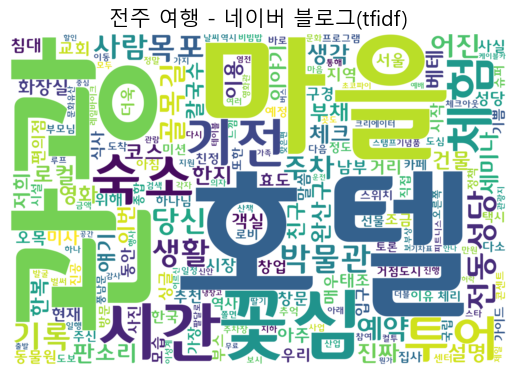

In [32]:
cloud = wc.generate_from_frequencies(tfidf_counter(temp_df1['text clean']))
plt.imshow(cloud, interpolation='bilinear')
plt.title("전주 여행 - 네이버 블로그(tfidf)", fontsize = 15)
plt.axis('off')
plt.show()